# Experimenting with Compression Matrix Learning in Torch

In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA = './data'
batch_size = 32
dataset = "fmnist"

if dataset == "fmnist":
    trainset = FashionMNIST(DATA, train=True, transform=ToTensor(), target_transform=None, download=True)
    testset = FashionMNIST(DATA, train=False, transform=ToTensor(), target_transform=None, download=True)
else:
    trainset = MNIST(DATA, train=True, transform=ToTensor(), target_transform=None, download=True)
    testset = MNIST(DATA, train=False, transform=ToTensor(), target_transform=None, download=True)

train = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test = DataLoader(testset, batch_size=batch_size, shuffle=True)

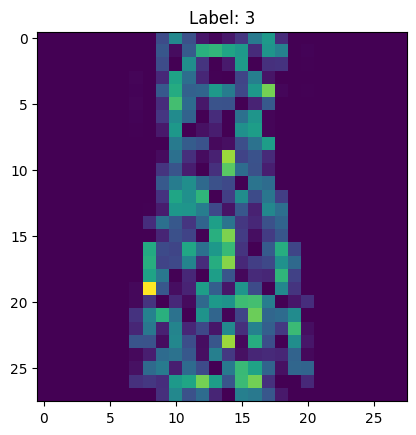

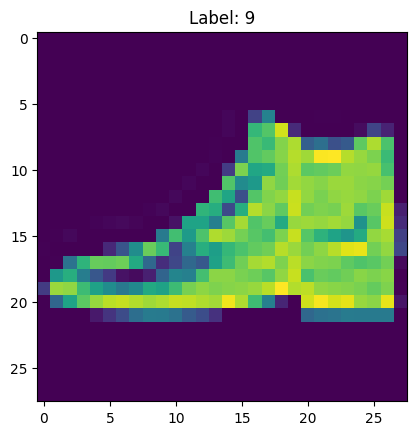

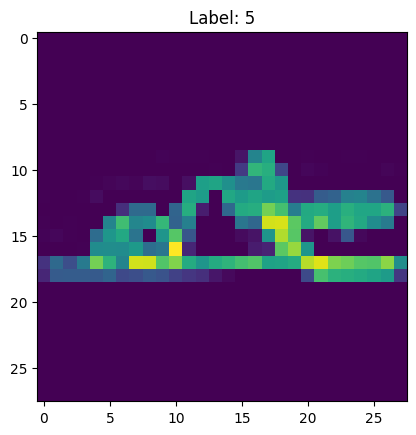

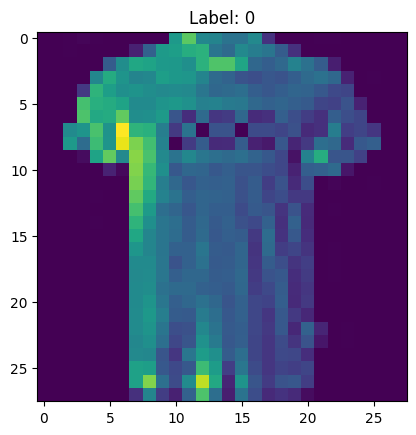

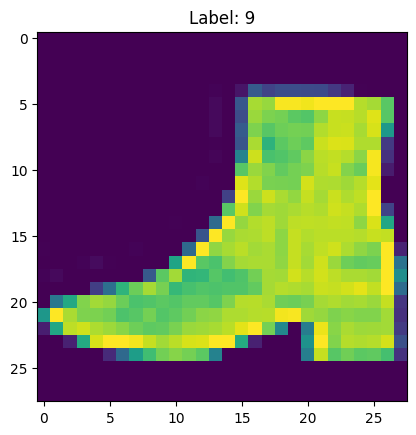

In [2]:
features, labels = next(iter(train))

# Plot a few members of the batch
for i in range(5):
    plt.figure()
    plt.title(f"Label: {labels[i]}")
    plt.imshow(features[i].squeeze())

## Implementing the Compression Matrix with Torch

$$\mathbf{z}=B^T\mathbf{x},\quad\mathbf{\tilde{x}}=B\mathbf{z}$$

where $B$ is the compression matrix, $\mathbf{z}$ is the compressed representation, and $\mathbf{\tilde{x}}$ is the reconstructed representation.

(Note to self: Torch represents the transform performed by a linear layer as $\mathbf{y}=\mathbf{x}A^T+\mathbf{b}.$)

In [3]:
class CompressionMatrix(torch.nn.Module):
    def __init__(self, input_dim, compressed_dim):
        super().__init__()
        
        # compressed_dim and input_dim passed in this order so that the weight attribute
        # has the same shape as the compression (B) matrix as described above.
        self.compression_matrix = torch.nn.Linear(compressed_dim, input_dim, bias=False)

    def forward(self, x):
        z = self.compression_matrix.weight.t()@x
        return self.compression_matrix(z.t())

    def encode(self, x):
        return self.compression_matrix.weight.t()@x

    def decode(self, z):
        return self.compression_matrix(z.t())

def avg_squared_error_loss(x, x_tilde):
    ''' Simple loss function '''
    loss = 0
    for i in range(batch_size):
        loss += (x[i] - x_tilde[i]).t()@(x[i] - x_tilde[i])
        
    return loss / batch_size

def compression_loss(x, x_tilde):
    ''' Compression loss function '''
    pass

## Training the Model

 epoch 1 batch 100 loss: 10.04409147644043
 epoch 1 batch 200 loss: 3.0370101051330565
 epoch 1 batch 300 loss: 2.6561320838928224
 epoch 1 batch 400 loss: 2.5352624034881592
 epoch 1 batch 500 loss: 2.378679672241211
 epoch 1 batch 600 loss: 2.349057340621948
 epoch 1 batch 700 loss: 2.353205097198486
 epoch 1 batch 800 loss: 2.3513276500701905
 epoch 1 batch 900 loss: 2.224894655227661
 epoch 1 batch 1000 loss: 2.132148307800293
 epoch 1 batch 1100 loss: 2.105542652130127
 epoch 1 batch 1200 loss: 2.103621738433838
 epoch 1 batch 1300 loss: 2.106004877090454
 epoch 1 batch 1400 loss: 2.0148970699310302
 epoch 1 batch 1500 loss: 2.0033829593658448
 epoch 1 batch 1600 loss: 1.9545670261383057
 epoch 1 batch 1700 loss: 1.9052380867004395
 epoch 1 batch 1800 loss: 1.8575495529174804
 epoch 2 batch 100 loss: 3.128751081466675
 epoch 2 batch 200 loss: 1.7523052425384522
 epoch 2 batch 300 loss: 1.6727301931381227
 epoch 2 batch 400 loss: 1.649792893409729
 epoch 2 batch 500 loss: 1.6425889

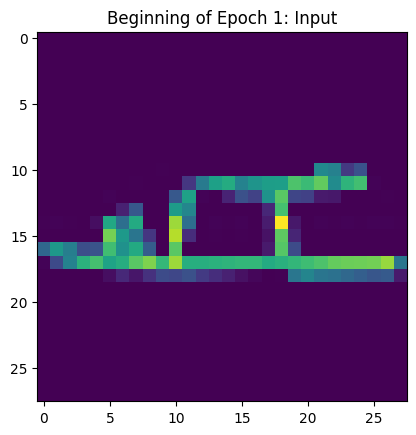

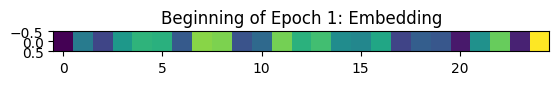

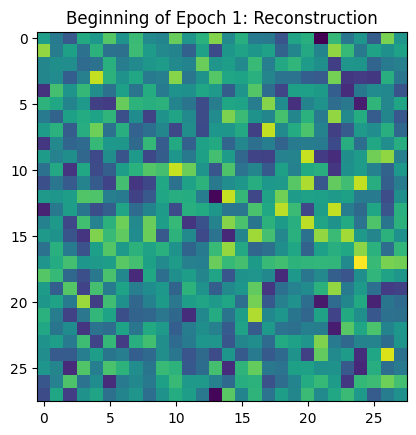

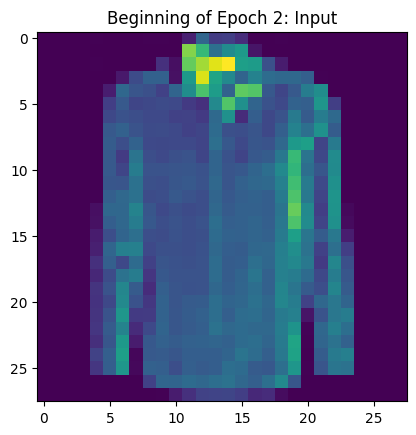

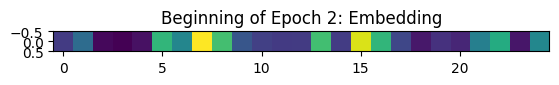

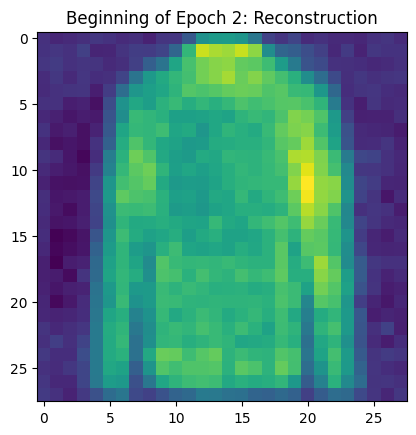

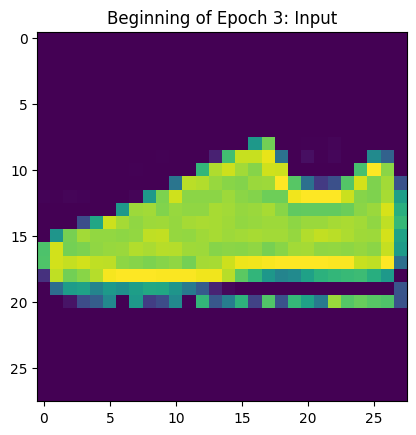

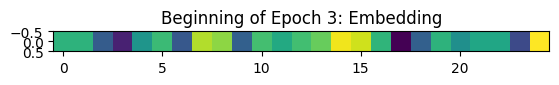

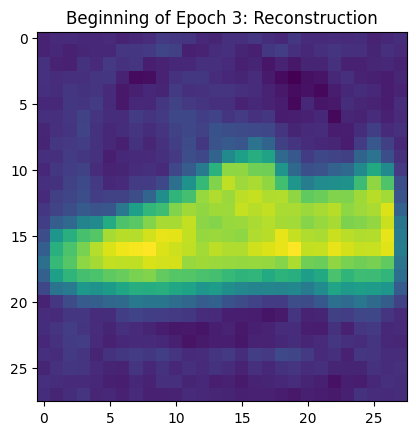

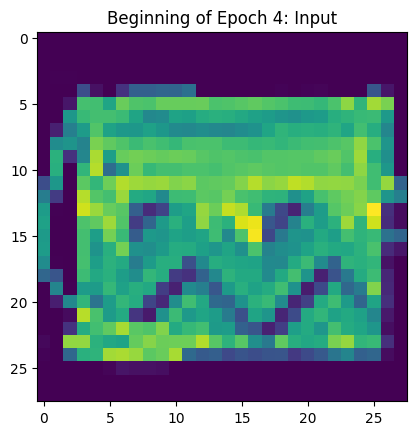

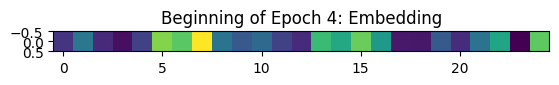

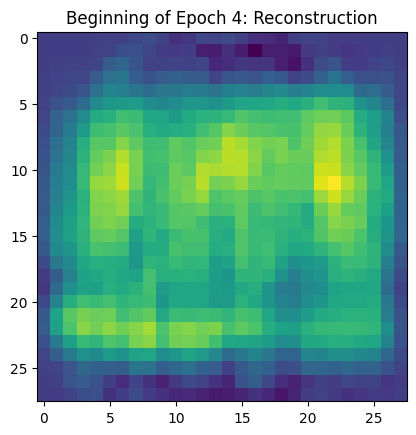

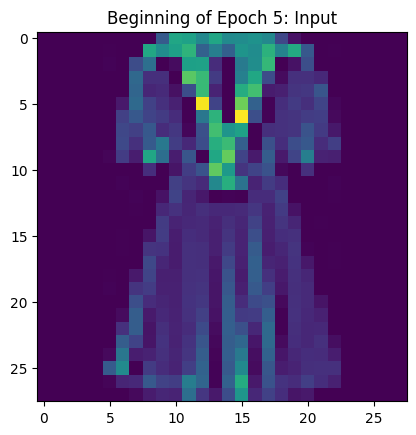

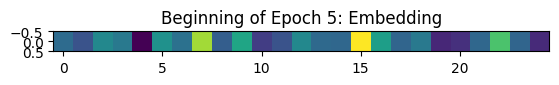

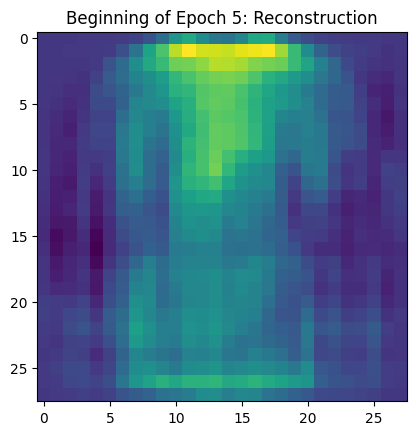

In [4]:
compressed_size = 25

# For MNIST and FMNIST, input dim is 28x28 = 784
if dataset in {"mnist", "fmnist"}:
    input_dim = 784

num_epochs = 5

compression_matrix = CompressionMatrix(input_dim, compressed_size)
optimizer = torch.optim.SGD(compression_matrix.parameters(), lr=0.001, momentum=0.9)
running_loss = 0.
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train):
        # Transpose because features need to be columns
        flat_features = torch.flatten(features, start_dim=1).t()
    
        # Zero the gradients
        optimizer.zero_grad()
    
        if i == 0:
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Input")
                
            plt.imshow(flat_features[:,1].reshape((28,28)))
    
        # Forward pass
        reconstructed = compression_matrix(flat_features)
    
        if i == 0:
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Embedding")
            plt.imshow(compression_matrix.encode(flat_features[:,1].t()).detach().reshape((1, compressed_size)))
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Reconstruction")
            plt.imshow(reconstructed[1].detach().reshape((28,28)))
    
        # Compute the loss and run the backward pass
        loss = avg_squared_error_loss(flat_features.t(), reconstructed)
        loss.backward()
    
        # Adjust the weights in response to the gradients
        optimizer.step()
    
        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print(' epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.